In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.optimize import curve_fit
import math
from tqdm import tqdm
import seaborn as sns
import numba as nb

from Preprocesses import MilkDataProcessor
from Bayesian import BayesianLinearRegression

%load_ext autoreload
%autoreload 2


<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Load data

In [2]:
processor = MilkDataProcessor('MilkData_OurDates/', 'MESAN_PROCESSED/')
processor.load_milk_data()
processor.add_weather_data()

milk_data_OG = processor.all_data

Merging weather and milk data: 100%|██████████| 9/9 [00:30<00:00,  3.35s/farm]


In [3]:
# Define the Wood's Lactation Curve function
def woods_lactation_curve(dim, a, b, c):
    dim = np.array(dim, dtype=float)
    return a * dim**b * np.exp(-c * dim)

# Function to fit the Wood's Lactation Curve to the dataset
def fit_woods_lactation_curve(dataset):
    # Initialize the 'ExpectedYield' column to NaN
    dataset['ExpectedYield'] = np.nan
    
    # Group the dataset by 'AnimalNumber' and fit the curve for each cow
    for animal_number, group in tqdm(dataset.groupby('SE_Number')):
        # Prepare the data for fitting
        x_data = group['DaysInMilk']
        y_data = group['DailyTotalYield']
        
        # Fit the model
        try:
            # Initial parameter guesses
            initial_guesses = [max(y_data), 0.4, 0.0001]
            # Bounds on the parameters to prevent overflow
            bounds = ([0, 0, 0], [np.inf, 1, 0.1])
            popt, pcov = curve_fit(
                woods_lactation_curve, x_data, y_data,
                p0=initial_guesses, bounds=bounds, maxfev=10000
            )
            
            # Predict the expected yield using the fitted model
            group['ExpectedYield'] = woods_lactation_curve(group['DaysInMilk'], *popt)
            
            # Normalize the DailyTotalYield
            group['NormalizedDailyTotalYield'] = group['DailyTotalYield'] / group['ExpectedYield']
            
            # Calculate the daily yield change and normalize it
            
            
            # Update the dataset with the fitted data
            dataset.loc[group.index, 'ExpectedYield'] = group['ExpectedYield']
            dataset.loc[group.index, 'NormalizedDailyTotalYield'] = group['NormalizedDailyTotalYield']
            
        except RuntimeError as e:
            print(f"Curve fit failed for cow {animal_number}: {e}")
    
    # Fill any NaN values in the newly created columns with 0
    dataset['ExpectedYield'].fillna(0, inplace=True)
    dataset['NormalizedDailyTotalYield'].fillna(0, inplace=True)
    
    return dataset


In [4]:
DATA = milk_data_OG.copy()
# Apply the curve fitting function to your dataset
DATA = DATA[(DATA['FarmName_Pseudo'] == 'a624fb9a') | (DATA['FarmName_Pseudo']=='f454e660')]


agg_functions = {
        'FarmName_Pseudo': 'first',
        'TotalYield': 'sum', # Daily sum of all the yields. Can be replaced with 'mean' to get daily mean instead
        'HW': 'first', # Since the HW indicator will be the same for all instances of the same day (given the same farm), we save the 'first'
        'cum_HW': 'first', # Same as for 'HW'
        'DaysInMilk': 'first', # Same as for 'HW'
        'LactationNumber': 'first', # Same as for 'HW'
        'Temperature': ['mean', 'max', 'min'], #Save both the daily Max temperature as well as daily mean temperature
        'Relative Humidity': 'mean', # Save daily mean humidity
        'THI_adj': 'mean' # save daily mean THI-adjusted
    }

breed_dummies = pd.get_dummies(DATA['BreedName'], prefix='Breed').astype(int)
breed_agg_functions = {breed: 'first' for breed in list(breed_dummies.columns)}
DATA = pd.get_dummies(DATA, columns=['BreedName'], prefix='Breed', dtype=int)

agg_functions = {**agg_functions, **breed_agg_functions}
daily_DATA = DATA.groupby(['SE_Number', 'StartDate']).agg(agg_functions).reset_index() #Group by day (StartDate)

# Remove the weird 'first' prefixes from the column names
daily_DATA.columns = [' '.join(col).strip() if 'first' not in col[1] else col[0] for col in daily_DATA.columns.values] 

# rename the columns to approiate prefixes
daily_DATA = daily_DATA.rename(columns={
    'TotalYield sum': 'DailyTotalYield',
    'DaysInMilk first': 'DaysInMilk',
    'Temperature mean': 'MeanTemperature',
    'Temperature max': 'MaxTemperature',
    'Temperature min': 'MinTemperature',
    'Relative Humidity mean': 'MeanRelHumidity',
    'THI_adj mean': 'MeanTHI_adj'
})
daily_data = fit_woods_lactation_curve(daily_DATA)
daily_data.head()

  1%|          | 4/376 [00:00<00:25, 14.61it/s]c:\Users\axele\.conda\envs\Doris\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 98%|█████████▊| 370/376 [00:17<00:00, 23.67it/s]c:\Users\axele\.conda\envs\Doris\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 376/376 [00:17<00:00, 21.18it/s]


,SE_Number,StartDate,FarmName_Pseudo,DailyTotalYield,HW,cum_HW,DaysInMilk,LactationNumber,MeanTemperature,MaxTemperature,MinTemperature,MeanRelHumidity,MeanTHI_adj,Breed_01 SRB,Breed_02 SLB,Breed_04 SJB,Breed_41 Fjällko,Breed_99 Korsning/obestämbar ras,ExpectedYield,NormalizedDailyTotalYield
0,SE-064c0cec-1189,2022-01-01,a624fb9a,30.77,0,0.0,191.0,7,-3.150000,-2.3,-4.0,92.900000,28.581350,0,1,0,0,0,29.739372,1.034655
1,SE-064c0cec-1189,2022-01-02,a624fb9a,48.22,0,0.0,192.0,7,-0.500000,0.3,-2.1,99.033333,32.830300,0,1,0,0,0,29.692059,1.624003
2,SE-064c0cec-1189,2022-01-03,a624fb9a,30.53,0,0.0,193.0,7,2.600000,2.9,2.3,97.300000,37.434160,0,1,0,0,0,29.644756,1.029862
3,SE-064c0cec-1189,2022-01-04,a624fb9a,42.26,0,0.0,194.0,7,-0.466667,-0.1,-1.1,93.300000,32.369387,0,1,0,0,0,29.597463,1.427825
4,SE-064c0cec-1189,2022-01-05,a624fb9a,38.49,0,0.0,195.0,7,-3.900000,-0.9,-5.9,87.133333,26.946920,0,1,0,0,0,29.550181,1.302530


In [5]:
cow = 'SE-a624fb9a-1297' # <--------- Adjust here  SE-a624fb9a-1261 SE-a624fb9a-1297
daily_cow_data = daily_data[daily_data['SE_Number'] == cow].copy()
print(f"The daily records dataframe for cow {cow} has {daily_cow_data.shape[0]} entries and {daily_cow_data.shape[1]} columns")
daily_cow_data.head(3)

The daily records dataframe for cow SE-a624fb9a-1297 has 628 entries and 20 columns


,SE_Number,StartDate,FarmName_Pseudo,DailyTotalYield,HW,cum_HW,DaysInMilk,LactationNumber,MeanTemperature,MaxTemperature,MinTemperature,MeanRelHumidity,MeanTHI_adj,Breed_01 SRB,Breed_02 SLB,Breed_04 SJB,Breed_41 Fjällko,Breed_99 Korsning/obestämbar ras,ExpectedYield,NormalizedDailyTotalYield
18256,SE-a624fb9a-1297,2022-01-01,a624fb9a,66.96,0,0.0,40.0,3,-2.98,-0.9,-4.2,93.64,27.914416,1,0,0,0,0,59.382117,1.127612
18257,SE-a624fb9a-1297,2022-01-02,a624fb9a,44.95,0,0.0,41.0,3,0.65,1.0,0.3,99.30,35.673170,1,0,0,0,0,59.462496,0.755939
18258,SE-a624fb9a-1297,2022-01-03,a624fb9a,77.94,0,0.0,42.0,3,2.20,3.8,0.4,98.78,36.870912,1,0,0,0,0,59.533619,1.309176


In [10]:
selected_feats = ['HW','cum_HW', 'MaxTemperature','MinTemperature','MeanTemperature', 'MeanRelHumidity', 'MeanTHI_adj'] #+ list(breed_dummies.columns)
BM = BayesianLinearRegression(daily_cow_data,
                              subject_name=cow,
                              selected_features=selected_feats,
                              target=['NormalizedDailyTotalYield'],
                              off_set_bool = True,
                              subject_type = 'cow')
results = BM.fit_model()


In [11]:
results

{'Off-set': {'mu': 0.9001161881413395, 'sigma': 0.11965746525797774},
 'HW': {'mu': -0.04645798446798466, 'sigma': 0.1002317456838534},
 'cum_HW': {'mu': 0.016785755295593674, 'sigma': 0.07808093441445046},
 'MaxTemperature': {'mu': 0.032177743248175794, 'sigma': 0.006244872252629796},
 'MinTemperature': {'mu': 0.0031550196558240984,
  'sigma': 0.006483738442631727},
 'MeanTemperature': {'mu': -0.028847272740672836,
  'sigma': 0.012503264218233022},
 'MeanRelHumidity': {'mu': 0.0027425367595927397,
  'sigma': 0.0005000588050194659},
 'MeanTHI_adj': {'mu': -0.005075703030911427, 'sigma': 0.002988579089067897}}

c:\Users\axele\OneDrive\Documents\Aår 5\Projekt\temp_project_git\Bayesian.py:382: UserWarning: Legend does not support handles for Axes instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  # Set text color in the legend to a hex color


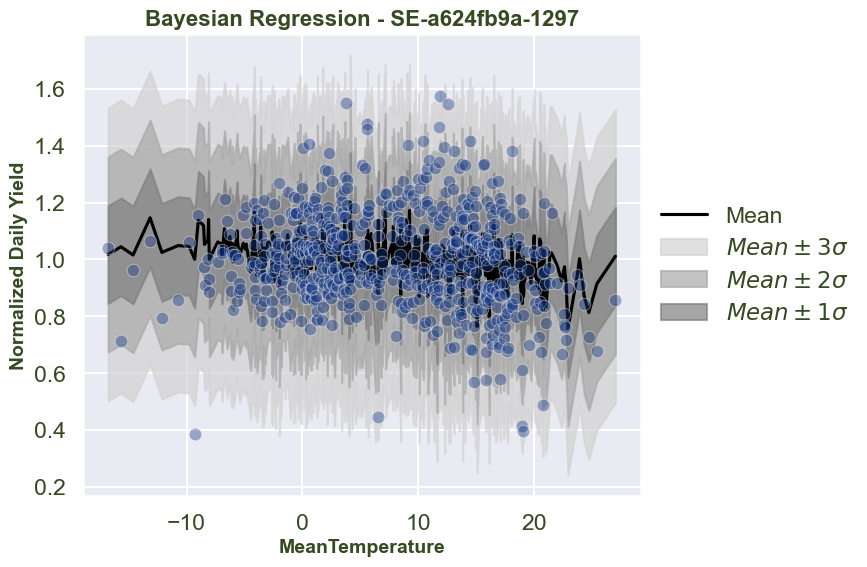

In [42]:
fig = BM.plot_model_uncertainty(ordered_by = 'MeanTemperature')
plt.savefig('model1_uncerts.png', transparent=True)

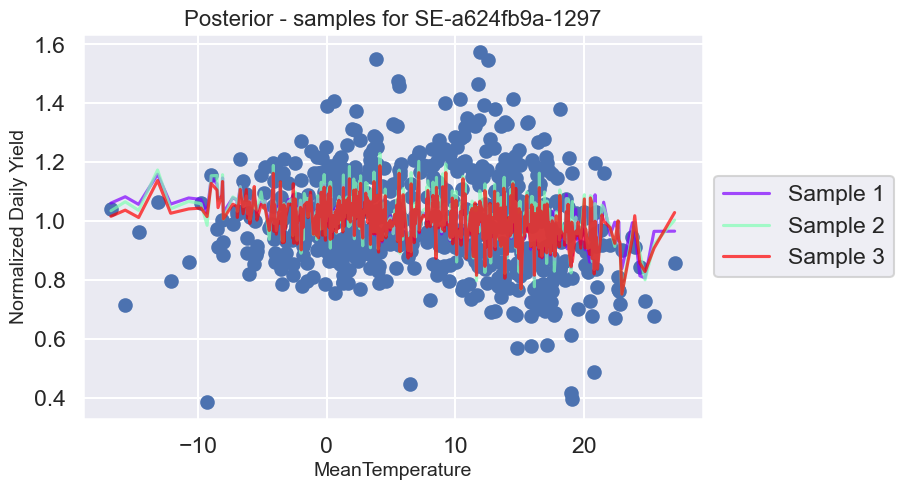

In [30]:
fig = BM.plot_model_samples(ordered_by='MeanTemperature',n_samples=3)
plt.savefig('model1_samples.png', transparent=True)

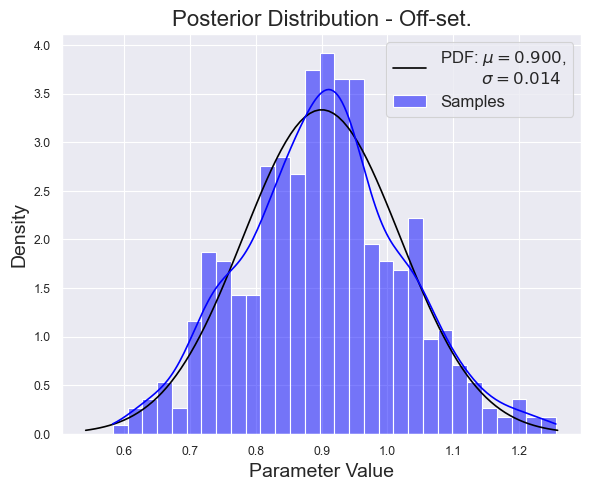

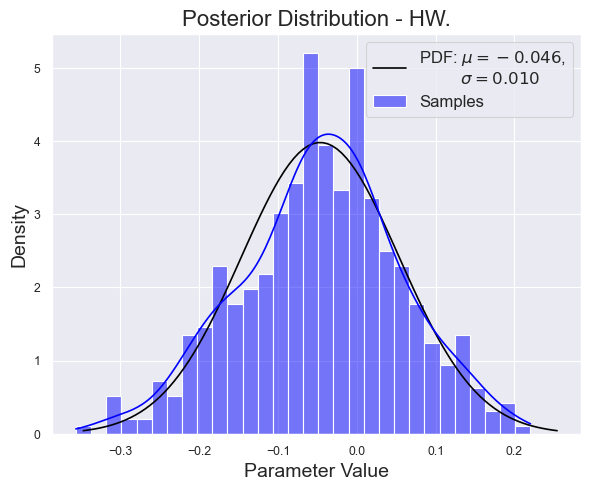

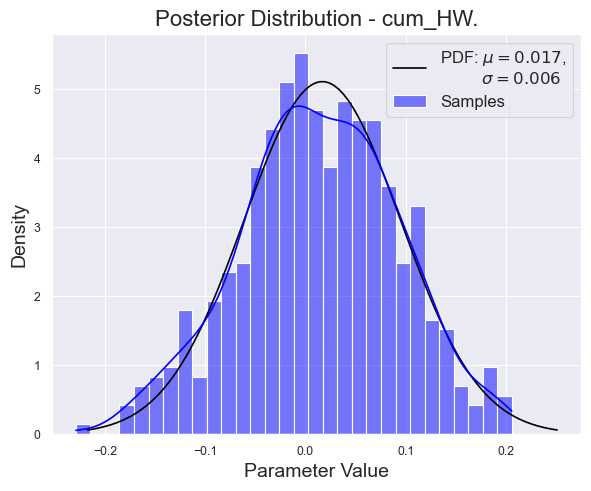

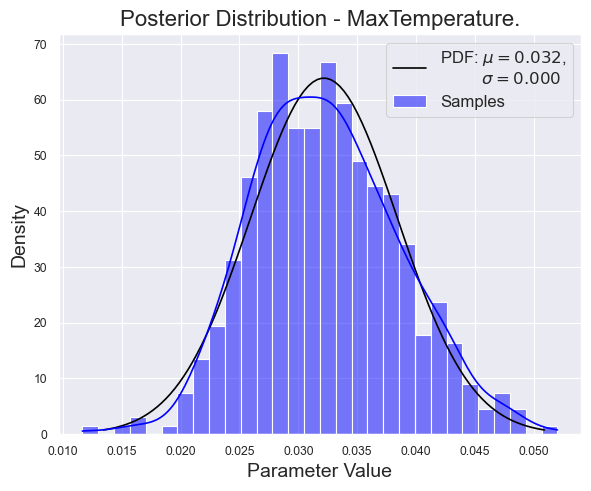

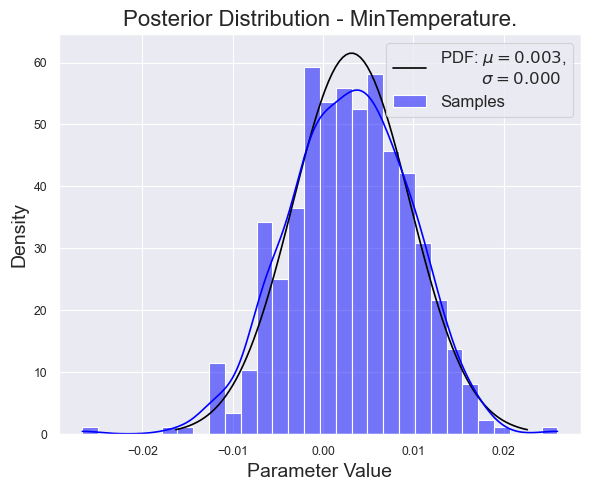

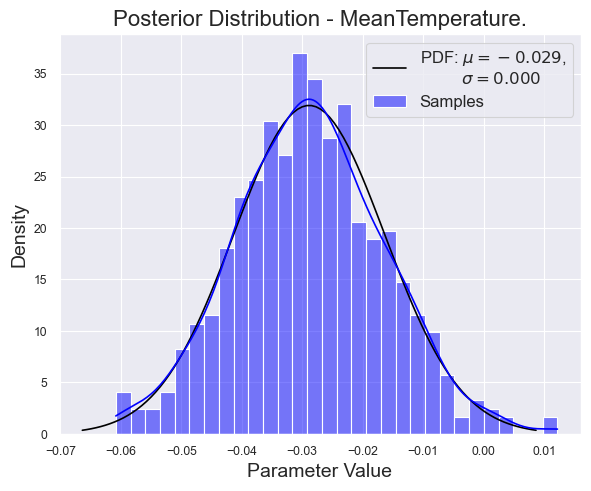

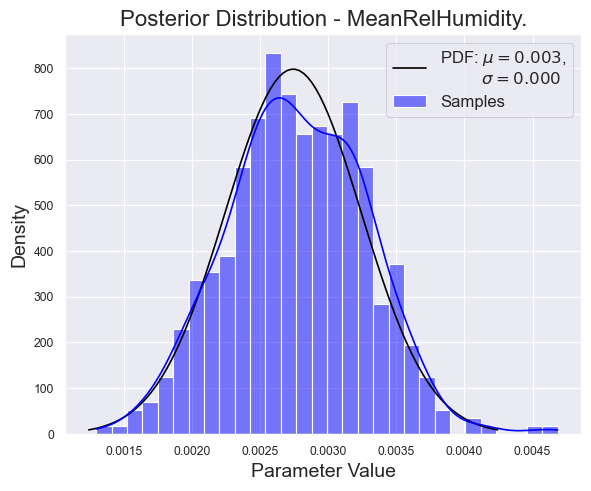

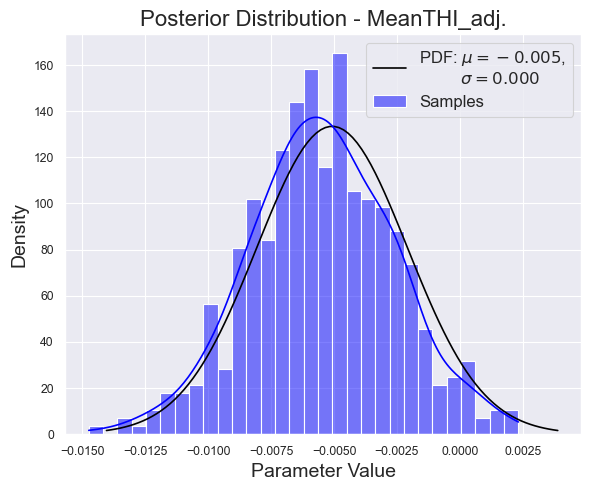

In [247]:
figs = BM.plot_posterior_distributions()
for i, f in enumerate(figs):
    f.savefig(f'model1_cow_dist_{i}.png')

In [44]:
farm = 'f454e660'
daily_farm_data = daily_data[daily_data['FarmName_Pseudo'] == farm].copy()
cows_list = list(daily_farm_data['SE_Number'].unique())
all_cows_result = {}

for cow in tqdm(cows_list):
    daily_cow_data = daily_farm_data[daily_farm_data['SE_Number'] == cow]
    if daily_cow_data.empty:
        continue
    selected_feats = ['HW','cum_HW', 'DaysInMilk', 'LactationNumber', 'MaxTemperature','MinTemperature','MeanTemperature', 'MeanRelHumidity', 'MeanTHI_adj'] + list(breed_dummies.columns)
    BM = BayesianLinearRegression(daily_cow_data,
                              subject_name=cow,
                              selected_features = selected_feats,
                              target = ['NormalizedDailyTotalYield'],
                              off_set_bool = True,
                              subject_type = None)
    
    all_cows_result[cow] = BM.fit_model()

result_df = pd.DataFrame(all_cows_result).transpose()
selected_feats = ['HW','cum_HW', 'DaysInMilk', 'LactationNumber', 'MaxTemperature','MinTemperature','MeanTemperature', 'MeanRelHumidity', 'MeanTHI_adj'] + list(breed_dummies.columns)
BM = BayesianLinearRegression(daily_farm_data,
                              subject_name=farm,
                              selected_features=selected_feats,
                              target=['NormalizedDailyTotalYield'],
                              off_set_bool = True,
                              subject_type = None)

farm_result = BM.fit_model()
breed_posterior = {}
for breed in list(breed_dummies.columns):
    breed_posterior[breed] = farm_result[breed]

result_df.index.name = 'SE_Number'
result_df.reset_index(inplace=True)
result_df.head(1)

 95%|█████████▌| 210/220 [00:02<00:00, 77.44it/s]c:\Users\axele\OneDrive\Documents\Aår 5\Projekt\temp_project_git\Bayesian.py:134: RuntimeWarning: divide by zero encountered in scalar divide
  self.beta = 1 / np.var(self.y + 1e-6)
c:\Users\axele\OneDrive\Documents\Aår 5\Projekt\temp_project_git\Bayesian.py:151: RuntimeWarning: invalid value encountered in multiply
  np.linalg.inv(self.prior_cov) + self.beta * self.Phi.T @ self.Phi
c:\Users\axele\OneDrive\Documents\Aår 5\Projekt\temp_project_git\Bayesian.py:151: RuntimeWarning: invalid value encountered in matmul
  np.linalg.inv(self.prior_cov) + self.beta * self.Phi.T @ self.Phi
c:\Users\axele\OneDrive\Documents\Aår 5\Projekt\temp_project_git\Bayesian.py:156: RuntimeWarning: invalid value encountered in multiply
  + self.beta * self.Phi.T @ self.y_reshaped
100%|██████████| 220/220 [00:03<00:00, 73.03it/s]


,SE_Number,Off-set,HW,cum_HW,DaysInMilk,LactationNumber,MaxTemperature,MinTemperature,MeanTemperature,MeanRelHumidity,MeanTHI_adj,Breed_01 SRB,Breed_02 SLB,Breed_04 SJB,Breed_41 Fjällko,Breed_99 Korsning/obestämbar ras
0,SE-7fd04cd3-679,"{'mu': -1.677925707626801e-05, 'sigma': 0.9999...","{'mu': 0.0, 'sigma': 1.0}","{'mu': 0.0, 'sigma': 1.0}","{'mu': 0.003986302797375885, 'sigma': 0.030650...","{'mu': -6.717219934511409e-05, 'sigma': 0.9999...","{'mu': 0.00590389205360764, 'sigma': 0.9309813...","{'mu': 0.005903892091165153, 'sigma': 0.930981...","{'mu': 0.005903892091165153, 'sigma': 0.930981...","{'mu': 0.0013073256217760619, 'sigma': 0.36388...","{'mu': -0.014633448821860018, 'sigma': 0.51676...","{'mu': 0.0, 'sigma': 1.0}","{'mu': 0.0, 'sigma': 1.0}","{'mu': -1.6791571852081688e-05, 'sigma': 0.999...","{'mu': 0.0, 'sigma': 1.0}","{'mu': 0.0, 'sigma': 1.0}"


In [235]:
breed_posterior

{'Breed_01 SRB': {'mu': 0.7624223074821472, 'sigma': 0.010184757022325724},
 'Breed_02 SLB': {'mu': 0.7603441638051223, 'sigma': 0.01004108319176354},
 'Breed_04 SJB': {'mu': 0.7682577267585344, 'sigma': 0.010142584952946244},
 'Breed_41 Fjällko': {'mu': 0.7409414534972711, 'sigma': 0.013341422994381949},
 'Breed_99 Korsning/obestämbar ras': {'mu': 0.7659119191622352,
  'sigma': 0.01009320922207}}

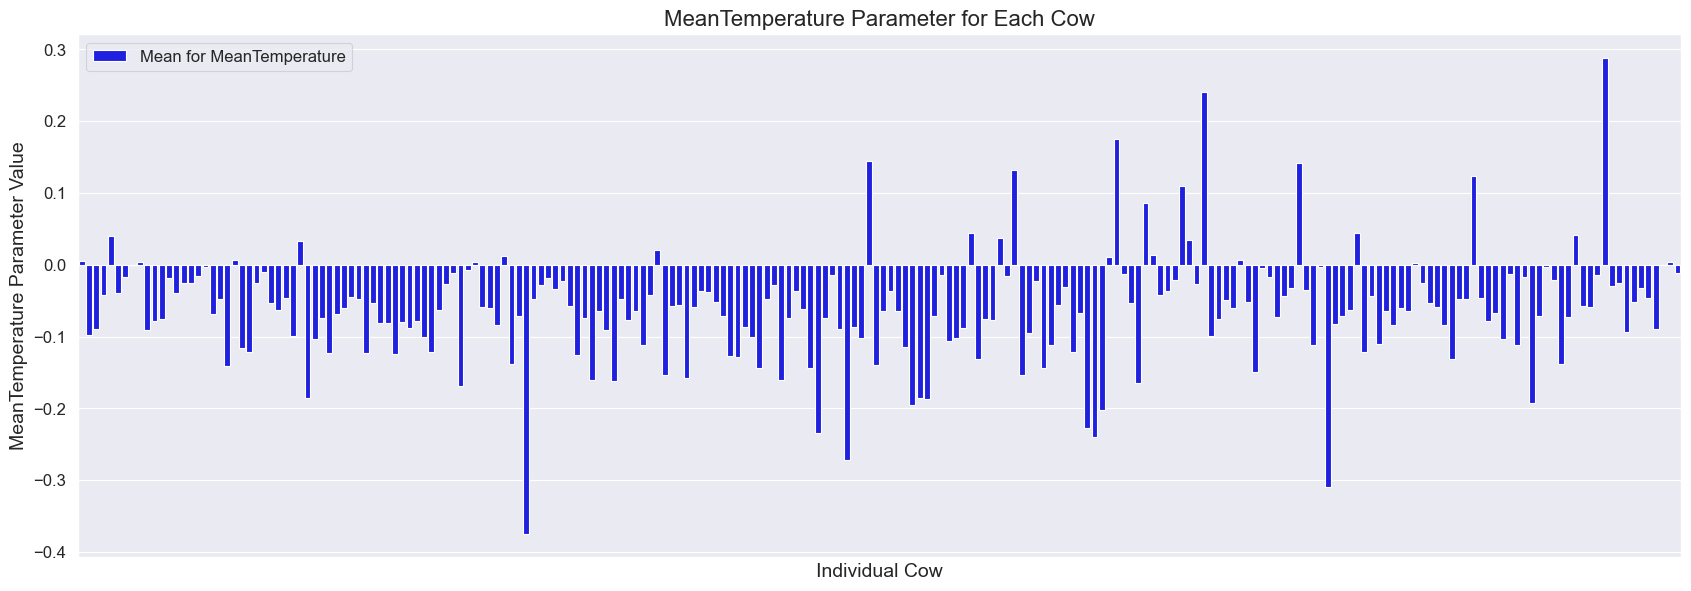

In [250]:
selected_parameter = 'MeanTemperature'
mu_values1 = result_df[selected_parameter].apply(lambda x: x['mu'])

plt.figure(figsize=(17, 6))
sns.barplot(x=mu_values1.index, y=mu_values1, color='blue', label=f"Mean for {selected_parameter}")
plt.xlabel('Cow Index', fontsize=14)
plt.ylabel(f'{selected_parameter} Parameter Value', fontsize=14)
plt.title(f'{selected_parameter} Parameter for Each Cow', fontsize=16)

# Adjust x-ticks labels to display 'Cow i'
plt.xticks(ticks=range(len(mu_values1)), labels=[f'Cow {i+1}' for i in range(len(mu_values1))], fontsize=7, rotation=90)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()
# plt.savefig('BAR_mean_farm.pdf', dpi=300)

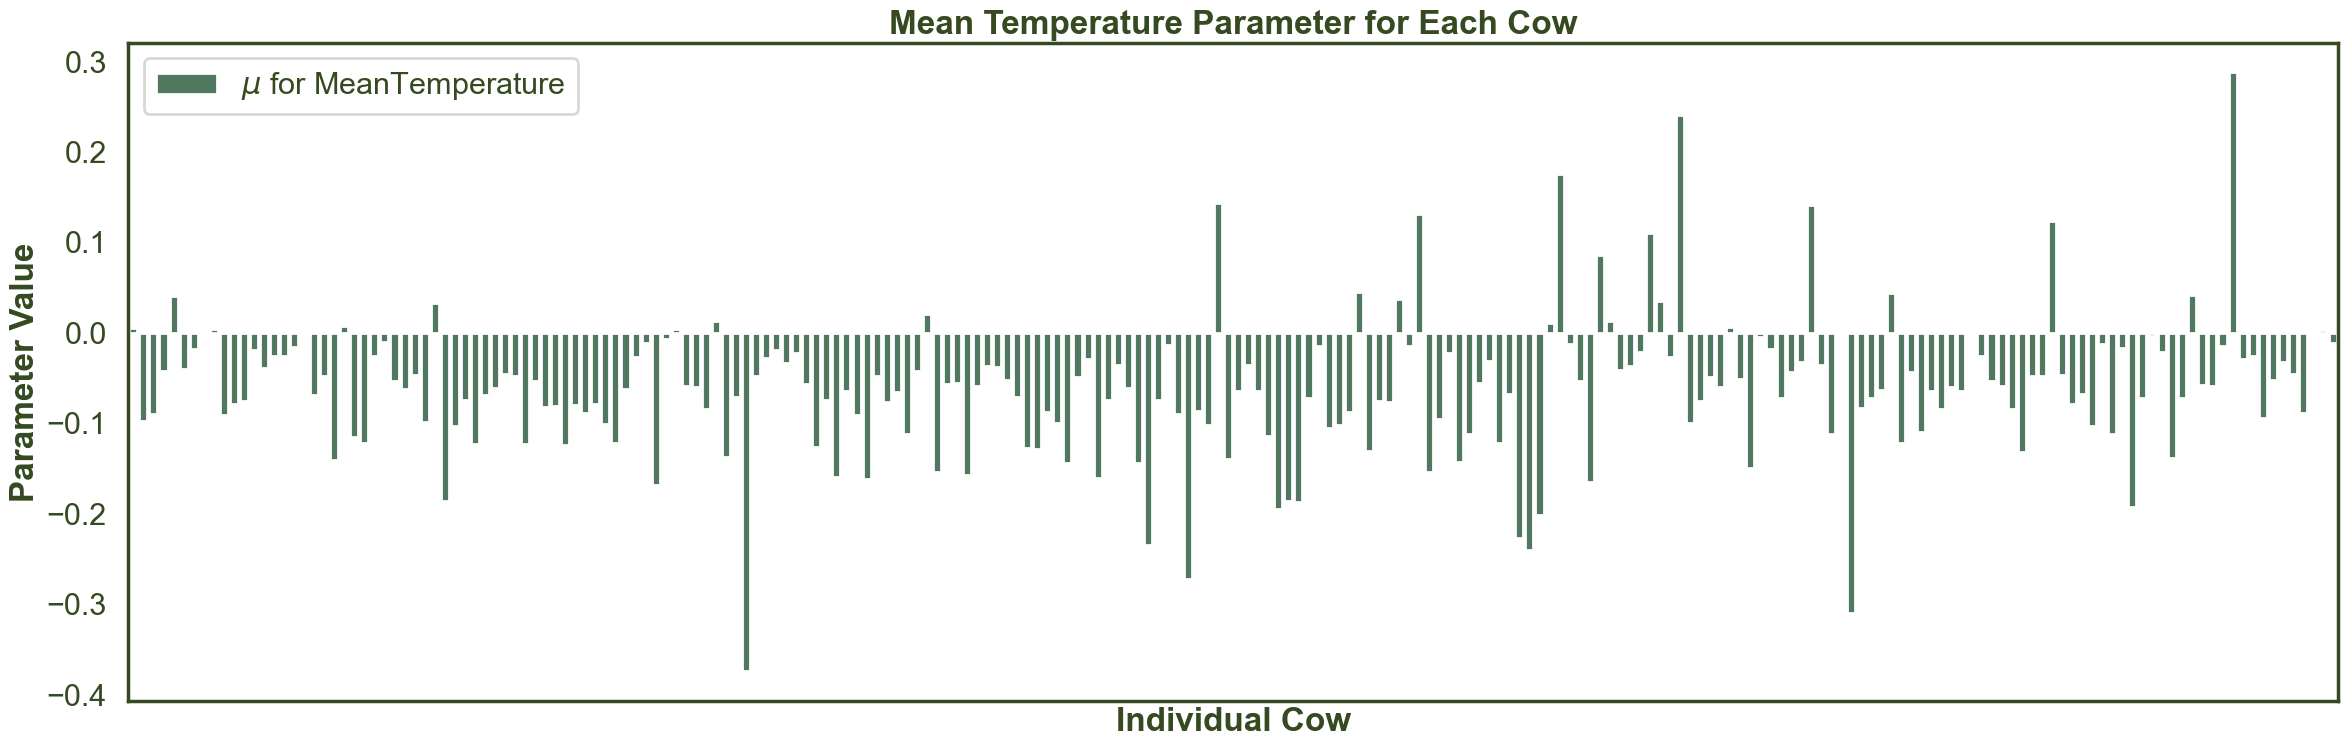

In [49]:
sns.set_theme(style="white")
sns.set_context("poster")

selected_parameter = 'MeanTemperature'
mu_values1 = result_df[selected_parameter].apply(lambda x: x['mu'])

fig, ax = plt.subplots(figsize=(24, 8))
sns.barplot(x=mu_values1.index, y=mu_values1, color='#497F5C', label=f"$\mu$ for {selected_parameter}", ax=ax)

ax.set_xlabel('Individual Cow', color='#354A21', weight='bold')
ax.set_ylabel(f'Parameter Value', color='#354A21', weight='bold')
ax.set_title(f'Mean Temperature Parameter for Each Cow', color='#354A21', weight='bold')

# Adjust x-ticks labels to display 'Cow i' but remove the values
ax.set_xticks([])
ax.set_xticklabels([])
leg=ax.legend(framealpha=0.2)
for text in leg.get_texts():
    text.set_color('#354A21')
leg.get_frame().set_edgecolor('#354A21')
# Customize the axes spines and tick labels
ax.spines['bottom'].set_color('#354A21')
ax.spines['left'].set_color('#354A21')
ax.spines['top'].set_color('#354A21')
ax.spines['right'].set_color('#354A21')
ax.tick_params(axis='y', colors='#354A21')

plt.tight_layout()
plt.gcf().set_facecolor('none')
plt.gcf().set_edgecolor('none')

# Save the plot as an SVG with transparent background
plt.savefig('CowParameterPlot.svg', format='svg', transparent=True)

In [52]:
breed_features = []
for n in list(result_df.columns):
    if 'Breed' in n:
        breed_features.append(n)

In [53]:
selected_parameter1 = 'Breed_01 SRB'
mu_values1 = result_df[selected_parameter1].apply(lambda x: x['mu'])

selected_parameter2 = 'Breed_02 SLB'
mu_values2 = result_df[selected_parameter2].apply(lambda x: x['mu'])

plt.figure(figsize=(17, 6))
sns.barplot(x=range(1, len(cows_list) + 1), y=mu_values1, color='blue', label = f"Mean for {selected_parameter1}")
sns.barplot(x=range(1, len(cows_list) + 1), y=mu_values2, color='red', label = f"Mean for {selected_parameter2}")
plt.xlabel('Cow Index', fontsize=14)
plt.xticks(ticks=range(1, len(cows_list) + 1), labels=[f'Cow {i}' for i in range(1, len(cows_list) + 1)], fontsize=8, rotation=90)

plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

AttributeError: 'bool' object has no attribute 'all'

<Figure size 1700x600 with 0 Axes>

In [251]:
farm2 = 'f454e660' # <--------- Adjust here  
daily_farm_data2 = daily_data[daily_data['FarmName_Pseudo'] == farm2].copy()
print(f"The daily records dataframe for cow {farm2} has {daily_farm_data2.shape[0]} entries and {daily_farm_data2.shape[1]} columns")

farm1 = 'a624fb9a' # <--------- Adjust here  
daily_farm_data1 = daily_data[daily_data['FarmName_Pseudo'] == farm1].copy()
print(f"The daily records dataframe for cow {farm1} has {daily_farm_data1.shape[0]} entries and {daily_farm_data1.shape[1]} columns")


The daily records dataframe for cow f454e660 has 84114 entries and 20 columns
The daily records dataframe for cow a624fb9a has 60564 entries and 20 columns


In [255]:
selected_feats = ['HW','cum_HW', 'DaysInMilk', 'LactationNumber', 'MaxTemperature','MinTemperature','MeanTemperature', 'MeanRelHumidity', 'MeanTHI_adj'] + list(breed_dummies.columns)
BM1 = BayesianLinearRegression(daily_farm_data1,
                              subject_name=farm1,
                              selected_features=selected_feats,
                              target=['NormalizedDailyTotalYield'],
                              off_set_bool = False,
                              subject_type = 'Farm')

farm_result1 = BM1.fit_model()
selected_feats = ['HW','cum_HW', 'DaysInMilk', 'LactationNumber', 'MaxTemperature','MinTemperature','MeanTemperature', 'MeanRelHumidity', 'MeanTHI_adj'] + list(breed_dummies.columns)
BM2 = BayesianLinearRegression(daily_farm_data2,
                              subject_name=farm2,
                              selected_features=selected_feats,
                              target=['NormalizedDailyTotalYield'],
                              off_set_bool = False,
                              subject_type = 'Farm')

farm_result2 = BM2.fit_model()

df1 = pd.DataFrame(farm_result1).transpose().reset_index()
df2 = pd.DataFrame(farm_result2).transpose().reset_index()

df1['Farm'] = 'Farm 1'
df2['Farm'] = 'Farm 2'


In [256]:
df1_breeds = df1[df1['index'].str.startswith('Breed')]
df1 = df1[~df1['index'].str.startswith('Breed')]

df2_breeds = df2[df2['index'].str.startswith('Breed')]
df2 = df2[~df2['index'].str.startswith('Breed')]


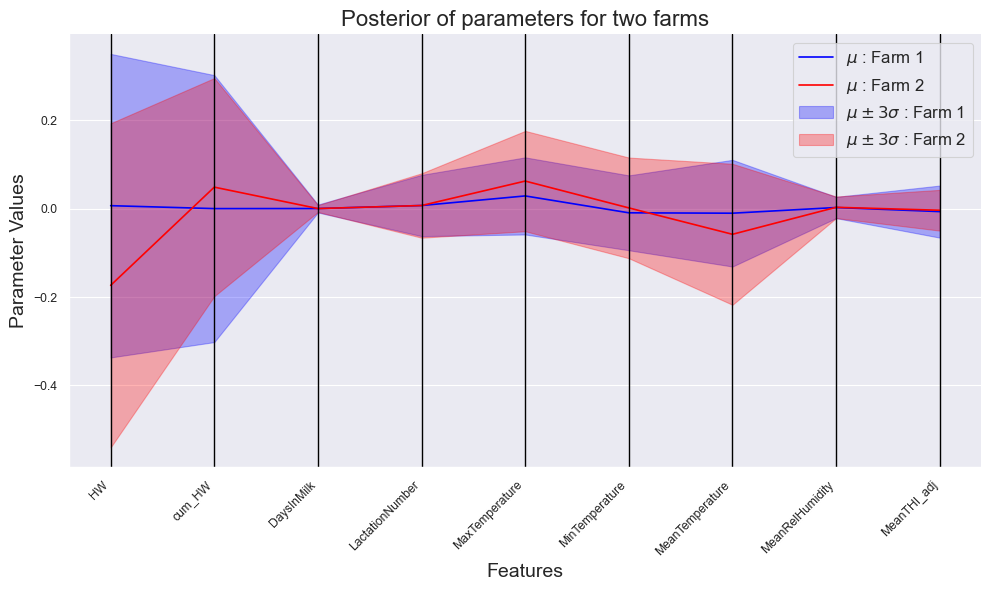

In [257]:
sns.set_theme()
sns.set_context("paper")
plt.figure(figsize=(10, 6))


# Line plot for 'mu' without style and palette
sns.lineplot(x='index', y='mu', data=df1, dashes=False, markers='o', label='$\mu$ : Farm 1', color='blue')
sns.lineplot(x='index', y='mu', data=df2, dashes=False, markers='o', label='$\mu$ : Farm 2', color='red')

# Fill_between for 'sigma' for Farm 1
plt.fill_between(df1['index'], df1['mu'] - 3*np.sqrt(df1['sigma']), df1['mu'] + 3*np.sqrt(df1['sigma']),
                 alpha=0.3, label='$\mu \pm 3 \sigma$ : Farm 1', color='blue')

# Fill_between for 'sigma' for Farm 2
plt.fill_between(df2['index'], df2['mu'] - 3*np.sqrt(df2['sigma']), df2['mu'] + 3*np.sqrt(df2['sigma']),
                 alpha=0.3, label='$\mu \pm 3 \sigma$ : Farm 2', color='red')

plt.xticks(rotation=45, ha='right')
plt.title('Posterior of parameters for two farms', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Parameter Values', fontsize=14)
plt.legend()
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
sns.despine()

# Manually add vertical lines at x-tick positions
for tick in plt.xticks()[0]:
    plt.axvline(tick, color='black', linestyle='-', linewidth=1)

plt.show()

In [259]:
print(farm1)
for index, row in df1_breeds.iterrows():
    print(f"{row['index']} mu {row['mu']:.4f} sigma {row['sigma']:.4f}")
print('-'*20)
print(farm2)
for index, row in df2_breeds.iterrows():
    print(f"{row['index']} mu {row['mu']:.4f} sigma {row['sigma']:.4f}")

a624fb9a
Breed_01 SRB mu 0.9231 sigma 0.0157
Breed_02 SLB mu 0.9196 sigma 0.0157
Breed_04 SJB mu 0.0000 sigma 1.0000
Breed_41 Fjällko mu 0.0000 sigma 1.0000
Breed_99 Korsning/obestämbar ras mu 0.0000 sigma 1.0000
--------------------
f454e660
Breed_01 SRB mu 0.7624 sigma 0.0102
Breed_02 SLB mu 0.7603 sigma 0.0100
Breed_04 SJB mu 0.7683 sigma 0.0101
Breed_41 Fjällko mu 0.7409 sigma 0.0133
Breed_99 Korsning/obestämbar ras mu 0.7659 sigma 0.0101
